# Basic Reinforcement Learning
Purpose: To learn about RL from its most basic instantiation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import copy

In [2]:
import gym

In [18]:
env = gym.make('LunarLander-v2')

In [14]:
env = gym.make('CartPole-v0')

In [ ]:
gym.Env()

In [20]:
env.reset()
env.state

AttributeError: 'LunarLander' object has no attribute 'state'

# Agent

In [21]:
class Vector_env(gym.Wrapper):
    '''
     class Vector_env
     
     Acts as a wrapper for the OpenAI gym environments.
    '''
    def __init__(self, env, n=1):
        '''
         venv = Vector_env(env, n=1)
         
         Creates n copies of env.
        '''
        super().__init__(env)
        self.envs = []
        for k in range(n):
            env_r = copy.deepcopy(env)
            env_r.seed(np.random.randint(10000))
            self.envs.append(env_r)
    
    def reset(self):
        '''
         states = venv.reset()
         
         Resets all the environments, and returns an array with the
         reset states in each row.
        '''
        states = []
        for e in self.envs:
            state = e.reset()
            states.append(state)
        return np.array(states)
    
    def step(self, actions):
        '''
         S, R, done, info = venv.step(actions)
         
         Takes one step in each of the environments, and returns an array
         for each of the resulting outputs.
         
         Inputs:
           actions   an array of actions
           
         Outputs:
           S    array of states after the step
           R    array of rewards from the step
           done array of Boolean flags:
                  False means episode continues
                  True means episode is done
        '''
        S, R, done = [], [], []
        for e,a in zip(self.envs, actions):
            s, r, d, inf = e.step(a)
            S.append(s)
            R.append(r)
            done.append(d)
        return np.array(S), np.array(R), np.array(done)
    
    def state(self):
        S = []
        for e in self.envs:
            S.append(e.state)
        return np.array(S)

In [36]:
obs = ag_r.envs.envs[0].reset()

In [37]:
obs

array([-0.00507193,  1.4151597 , -0.5137544 ,  0.18841419,  0.00588396,
        0.11637297,  0.        ,  0.        ], dtype=float32)

In [38]:
class Agent():
    '''
     class Agent
     
     Represents an RL agent. Its Q function is represented by a neural network, so that
       agent.Q(s) returns a vector of probabilities over action-space.
    '''
    def __init__(self, envs):
        '''
         ag = Agent(envs)
         
         Instantiates an Agent object.
         
         Inputs:
           envs  a Vector_env object, containing the environments for the task
        '''
        self.envs = envs
        self.state_dim = self.envs.observation_space.shape[0]  #state_dim
        self.n_actions = self.envs.action_space.n  #n_actions
        #self.state = torch.zeros(self.state_dim)
        self._max_episode_steps = 100
        
        # Policy
        self.hidden = 100
        self.Pi_net = torch.nn.Sequential(
                    torch.nn.Linear(self.state_dim, self.hidden),
                    torch.nn.Sigmoid(),
                    torch.nn.Linear(self.hidden, self.n_actions))
        
        # Value function
        self.V_hidden = 80
        self.V_net = torch.nn.Sequential(
                    torch.nn.Linear(self.state_dim, self.V_hidden),
                    torch.nn.Sigmoid(),
                    torch.nn.Linear(self.V_hidden, 1))
        
        # Eligibility-trace buffer for Pi_net
        self.Piz = []
        for p in self.Pi_net.parameters():
            self.Piz.append(torch.zeros_like(p))
            
        # Eligibility-trace buffer for V_net
        self.Vz = []
        for p in self.V_net.parameters():
            self.Vz.append(torch.zeros_like(p))
        
    def Pi(self, states=None):
        if states is None:
            S = torch.tensor(self.envs.state(), dtype=torch.float)
        else:
            S = torch.tensor(states, dtype=torch.float)
        return torch.distributions.Categorical(logits=self.Pi_net(S))
    
    def V(self, states=None):
        if states is None:
            S = torch.from_numpy(self.envs.state())
        else:
            S = torch.tensor(states, dtype=torch.float)
        return self.V_net(S)
    
    
    def ChooseAction(self, state=None, eps=0.):
        '''
         A = ag.ChooseAction(state, eps=0.)
         
         Choose an action, given the state.
         With probability eps, it will choose an action randomly.
         Otherwise, it will choose an action that yields the highest Q-value.
        '''
        if state is None:
            state = self.envs.state()
            
        batchsize = len(state)
        
        with torch.no_grad():
            Pa = self.Pi(state)
        A = Pa.sample().detach().numpy()
        
        # With prob eps, choose random action
        A_random = np.array(np.random.randint(0, high=self.n_actions, size=batchsize), dtype=np.float)
        r = np.random.rand(batchsize)
        ridx = r<eps
        A[ridx] = A_random[ridx]
        
        return A
    
    def Episode(self, gamma=1., eps=0.):
        '''
         traj = ag.Episode(gamma=1.)
         
         Runs one episode, and returns the trajectory. The environment is
         automatically reset at the beginning of the episode.
                 
         Inputs:
           gamma  reward discount
         
         Outputs:
           traj trajectory, as a list of lists of the form
                [A, S, Snext, R, G, done, info]
                A     action taken at state S
                S     state
                Snext state after taking action A
                R     reward
                G     future return (discounted)
                done  flag to indicate episode is done
                info  not sure ?
        '''
        S = self.envs.reset()
        traj = []
        bs = len(S)  # batchsize
        for k in range(self._max_episode_steps):
            action = self.ChooseAction(state=S, eps=eps)
            Snext, r, done = self.envs.step(action)
            traj.append(dict(action=action, S=S, Snext=Snext, r=r, G=np.zeros(bs), done=done))
            S = Snext
            if done.all():
                break
        # Use that trajectory (and rewards) to update the policy parameters
        # Process the return for all visited states
        #traj[-1][4] = np.zeros(bs)
        for k in range(len(traj)-2, -1, -1):
            traj[k]['G'] = traj[k]['r'] + (1.-traj[k]['done'])*gamma*traj[k+1]['G']
        return traj
    
    

    def Simulate(self, trials=1, eps=0.):
        time.sleep(1)
        avg_k = 0.
        for trial in range(trials):
            observation = self.envs.envs[0].reset()
            for k in range(self._max_episode_steps):
                self.envs.envs[0].render()
                action = self.ChooseAction(state=[observation], eps=eps)

                observation, reward, done, info = self.envs.envs[0].step(action[0])

                if done:
                    print('Done after '+str(k))
                    avg_k += k
                    break
        print('Average reward: '+str(avg_k/trials))
        time.sleep(1)
        self.envs.envs[0].close()
        
        
    def REINFORCE(self, gamma=1.0, alpha=0.0001, eps=0.):
        '''
         ag.REINFORCE(env, gamma=1.0, alpha=0.0001, eps=0.)
         
         Performs an episode of the REINFORCE algorithm, following a reset
         of the environment.
         
         Inputs:
           gamma  discount rate for rewards (default 1.0)
           alpha  step size for gradient ascent (the policy gradient)
           eps    probability of choosing a random action
           
         Output:
           traj   trajectory, a list of lists of the form:
                [A, S, Snext, R, G, done, info]
                A     action taken at state S
                S     state
                Snext state after taking action A
                R     reward
                G     future return (discounted)
                done  flag to indicate episode is done
                info  not sure ?
        '''
        # Perform an episode and record the trajectory
        traj = self.Episode(eps=eps)
        bs = len(traj[0]['action'])
                
        # Update policy parameters
        loss = 0.
        for k,blah in enumerate(traj):
            A = blah['action']  # actions
            G = torch.tensor(blah['G'], dtype=torch.float)  # future return
            S = blah['S']  # before states
            dones = blah['done']
            Pa = self.Pi(S)  # get action probabilities
            logPa_x_G = Pa.log_prob(torch.tensor(A)) * (G)
            loss += torch.mean(logPa_x_G)
            #print(loss)
        
        self.Pi_net.zero_grad()
        loss.backward()
            
        with torch.no_grad():
            for p in self.Pi_net.parameters():
                p += alpha * p.grad
        return traj

    
    def REINFORCE_baseline(self, gamma=1.0, alpha=0.0001, alpha_v=0.0001, eps=0.1):
        '''
         ag.REINFORCE_baseline(env, gamma=1.0, alpha=0.0001, alpha_v=0.0001)
         
         Performs an episode of the REINFORCE algorithm with baseline, following
         a reset of the environment. This method computes a model of the value
         function, in addition to a policy.
         
         Inputs:
           gamma  discount rate for rewards (default 1.0)
           alpha  step size for gradient ascent (the policy gradient)
           alpha_v step size for gradient ascent of the value function
           
         Output:
           traj   trajectory, a list of lists of the form:
                  [A, S, Snext, R, G, done, info]
                  A     action taken at state S
                  S     state
                  Snext state after taking action A
                  R     reward
                  G     future return (discounted)
                  done  flag to indicate episode is done
                  info  not sure ?
        '''
        v_mult = 1.
        
        # Perform an episode and record the trajectory
        traj = self.Episode(eps=eps(0))
        bs = len(traj[0]['action'])
                
        # Update policy parameters
        gamma_t = gamma
        Pa_loss = 0.
        V_loss = 0.
        for k,blah in enumerate(traj):
            A = blah['action']
            S = blah['S']
            G = torch.from_numpy(blah['G'])  # future return
            G.requires_grad = False
            dones = blah['done']
            
            # Policy network
            Pa = self.Pi(S)  # returns a distribution object
            
            # Value network
            V = self.V(S)*v_mult
            
            # Error
            with torch.no_grad():
                err = G - V
            
            # Recall that d(log(Pi)) = dPi / Pi
            logPa_x_err = Pa.log_prob(torch.from_numpy(A)) * err * gamma_t
            
            Pa_loss += torch.mean(logPa_x_err)
            V_loss += torch.mean( V*err ) * gamma_t
            
            gamma_t *= gamma
        
        # Backproject gradient
        self.Pi_net.zero_grad()
        self.V_net.zero_grad()
        Pa_loss.backward()
        V_loss.backward()
        with torch.no_grad():
            for p in self.Pi_net.parameters():
                p += alpha * p.grad
            for p in self.V_net.parameters():
                p += alpha_v * p.grad
            
        return traj


### Cart-Pole

In [62]:
#env = gym.make('CartPole-v0')
env = gym.make('LunarLander-v2')
S = env.reset()
envs = Vector_env(env, n=32)
ag_r = Agent(envs)
ag_r._max_episode_steps = 200

In [63]:
score = []
counter = 0
mysum = 0

In [64]:
interval = 50

In [72]:
for i_episode in range(400):
    traj = ag_r.REINFORCE_baseline(alpha=0.0001, alpha_v=0.0001, eps=(lambda x: 0.1))
    #traj = ag_r.REINFORCE(alpha=0.0001, eps=0.)
    counter += 1
    mysum += np.mean(traj[0]['G'])
    if counter%interval==0:
        print(counter)
        score.append(mysum/interval)
        mysum = 0

850
900
950
1000
1050
1100
1150
1200


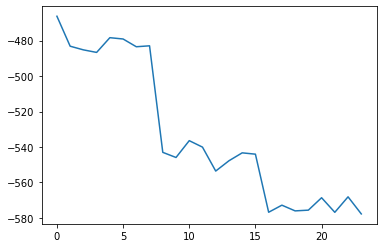

In [73]:
plt.plot(score);

In [96]:
ag_r.Simulate(3, eps=0.1)

Done after 55
Done after 128
Done after 110
Average reward: 97.66666666666667


In [32]:
ag_r.envs.envs[0].close()

## REINFORCE with Baseline

In [61]:
env = gym.make('CartPole-v0')

S = env.reset()
ag_rb = Agent(env)
ag_rb.env._max_episode_steps = 500

In [62]:
score2 = []
counter = 0
mysum = 0
interval = 50

In [76]:
for i_episode in range(200):
    traj = traj = ag_rb.REINFORCE_baseline(alpha=0.0001, alpha_v=0.0001)
    counter += 1
    mysum += len(traj)
    if counter%interval==0:
        score2.append(mysum/interval)
        mysum = 0

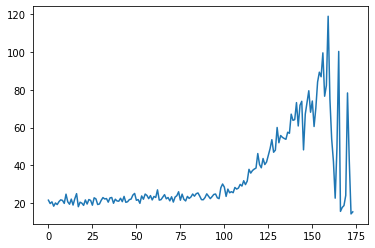

In [77]:
plt.plot(score2);

In [75]:
S = ag_rb.env.reset()
print(S)
ag_rb.V(torch.tensor(S, dtype=torch.float))

[-0.0245504   0.0344018  -0.00279386  0.02541287]


tensor([1.8533], grad_fn=<AddBackward0>)

In [63]:
ag_rb.V(torch.tensor([0, 0, 0, 0], dtype=torch.float))

tensor([17.9258], grad_fn=<AddBackward0>)